## Data loading

In [119]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Rain_prediction/datasets

/content/drive/MyDrive/Rain_prediction/datasets


In [3]:
X_train,X_test,X_val,y_train,y_test,y_val = pd.read_csv('X_train.csv'),pd.read_csv('X_test.csv' ),pd.read_csv('X_val.csv' ),pd.read_csv('y_train.csv'),pd.read_csv('y_test.csv'),pd.read_csv('y_val.csv')

### Imports and functions

In [120]:
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tensorflow.keras.layers import Dense,Dropout,Concatenate,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, fashion_mnist

from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, fetch_covtype, fetch_california_housing
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve

In [5]:
def plot_curves(history,name= "curves"):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(train_loss) + 1)
  chosen = len(train_loss) - 10
  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  print(f"Validation loss: {val_loss[chosen-1]}, Validation accuracy:{val_accuracy[chosen-1]} ")

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)
  axes[0].axvline(x=chosen, color='r', linestyle='--')

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training Accuracy')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation Accuracy')
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()
  axes[1].grid(True)
  axes[1].axvline(x=chosen, color='r', linestyle='--')

  plt.tight_layout()
  plt.savefig(f"{name}.png")
  plt.show()


Random seeds

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

### MLP specific preprocessing

Target need to be floats

In [7]:
mapping = {'Yes':1,'No':0}

y_train["RainTomorrow"] = y_train["RainTomorrow"].map(mapping)
y_test["RainTomorrow"] = y_test["RainTomorrow"].map(mapping)
y_val["RainTomorrow"] = y_val["RainTomorrow"].map(mapping)

Decorrelate for faster convergence

In [8]:
from sklearn.decomposition import PCA

pca = PCA()

X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)
X_val_PCA = pca.transform(X_val)

In [123]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True,random_state=42)
X_train_cv = np.concatenate((X_train_PCA, X_val_PCA), axis=0)
y_train_cv = np.concatenate((y_train, y_val), axis=0)

def cross_validate(model,name= "model",dataframe = None):
  accuracy_scores = []
  loss_scores = []
  f1_scores = []
  auc_scores = []
  precision_scores = []
  recall_scores = []
  for train_index, val_index in kfold.split(X_train_cv,y_train_cv):

    # Train the model
    model.fit(X_train_cv[train_index], y_train_cv[train_index], epochs=num_epochs, batch_size=batch_size, verbose=0,validation_data= (X_train_cv[val_index],y_train_cv[val_index]), callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_train_cv[val_index], y_train_cv[val_index])
    accuracy_scores.append(accuracy)
    loss_scores.append(loss)


    y_pred_prob = model.predict(X_train_cv[val_index])
    y_pred = (y_pred_prob >= 0.5).astype(int)

    precision = precision_score(y_train_cv[val_index], y_pred)
    recall = recall_score(y_train_cv[val_index], y_pred)
    f1 = f1_score(y_train_cv[val_index], y_pred)
    auc = roc_auc_score(y_train_cv[val_index], y_pred_prob)
    f1_scores.append(f1)
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    # Calculate average accuracy
  avg_accuracy = np.mean(accuracy_scores)
  avg_loss = np.mean(loss)
  avg_f1 = np.mean(f1_scores)
  avg_auc = np.mean(auc_scores)
  avg_precision = np.mean(precision_scores)
  avg_recall = np.mean(recall_scores)
  dataframe.loc[name] = {'Loss':avg_loss, 'Accuracy':avg_accuracy, 'F1':avg_f1, 'AUC':avg_auc, 'Precision':avg_precision, 'Recall':avg_recall}

  return dataframe

## Modelling

### Common parameters between models


In [10]:
# Define the optimizer and learning rate
learning_rate = 3e-4

# Early stopping
early_stopping = EarlyStopping(monitor="val_loss",  patience=10, restore_best_weights=True)

# Training settings
num_epochs = 1000
batch_size = 32

## Model 1

### PCA features

Let's try building a very small modell and go up gradually, lets test too if PCA improves the results

In [11]:
model_1 = Sequential([
    Dense(8, activation='relu', input_shape=(X_train_PCA.shape[1],)),
    Dense(1, activation='sigmoid')
])

In [12]:
model_1.compile(optimizer= Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_1.fit(X_train_PCA, y_train, epochs=num_epochs, batch_size=batch_size, validation_data= (X_val_PCA,y_val), callbacks=[early_stopping])

Validation loss: 0.41362178325653076, Validation accuracy:0.8108008503913879 


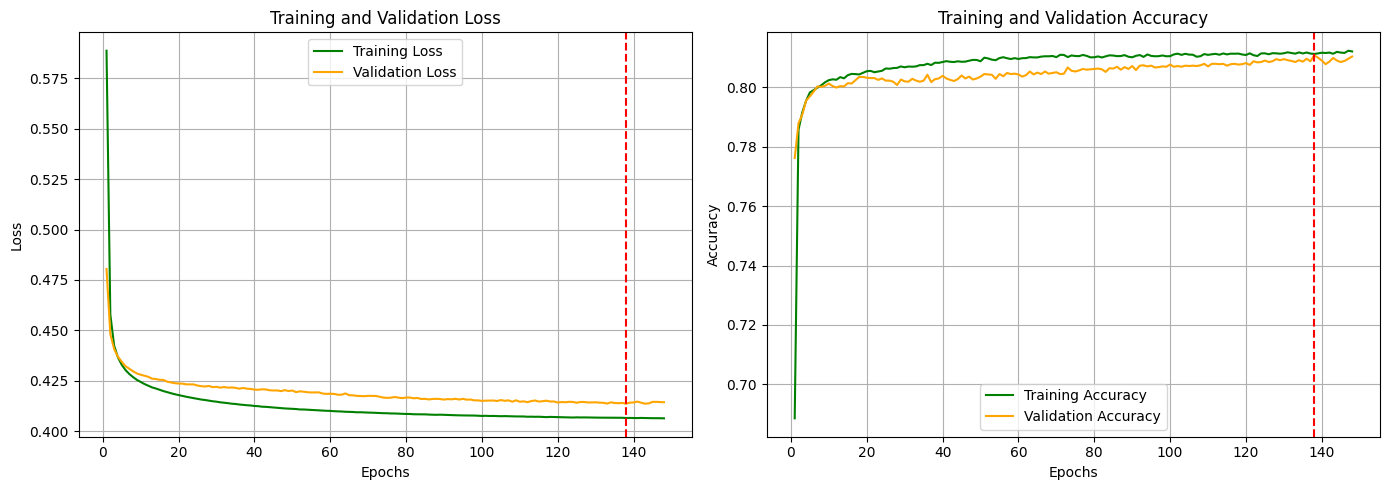

In [14]:
plot_curves(history,"model1")

We can see a good fit, tending to an underfit . Let's try to try and get more model capacity

In [66]:
cross_validate(model_1)

328/328 [==============================] - 0s 1ms/step - loss: 0.4041 - accuracy: 0.8164


(0.4040507674217224, 0.816369354724884)

### Without PCA


In [16]:
model_n = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_n.compile(optimizer =Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
history_n = model_n.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data= (X_val,y_val), callbacks=[early_stopping])

Validation loss: 0.4157831072807312, Validation accuracy:0.808217465877533 


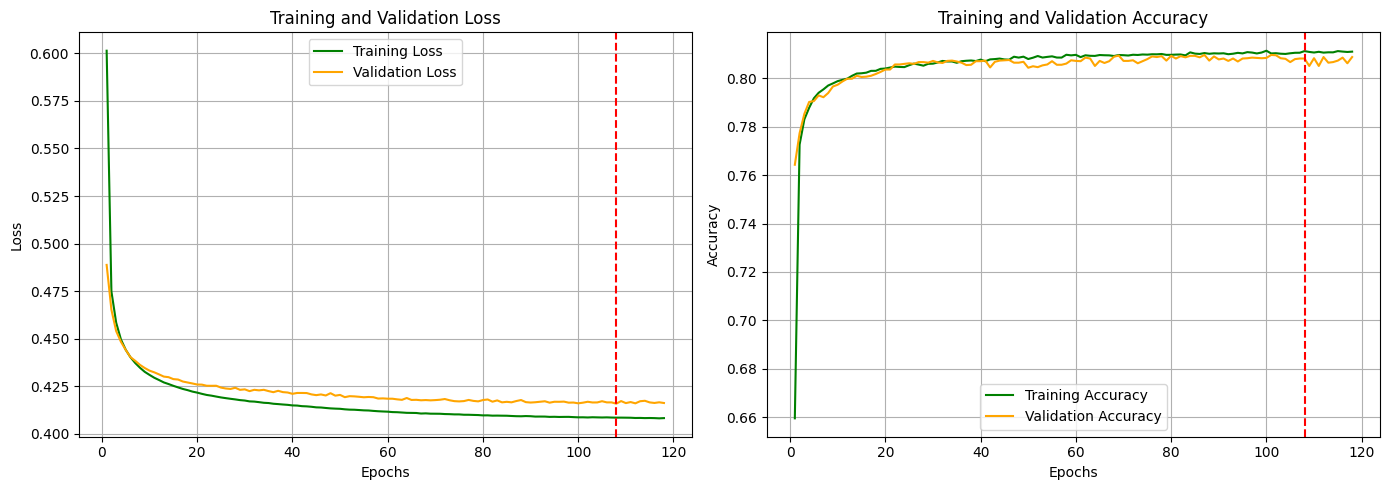

In [18]:
plot_curves(history_n)

We can see how model with PCA gets better results overall

## Model 2

In this model, lets try to add more neurons in order to augment capacity and try to get the perfect fit

In [19]:
model_2 = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_PCA.shape[1],)),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_2.compile(optimizer =Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(X_train_PCA, y_train, epochs=num_epochs, batch_size=batch_size, validation_data= (X_val_PCA,y_val), callbacks=[early_stopping])

Validation loss: 0.4134792983531952, Validation accuracy:0.8077254295349121 


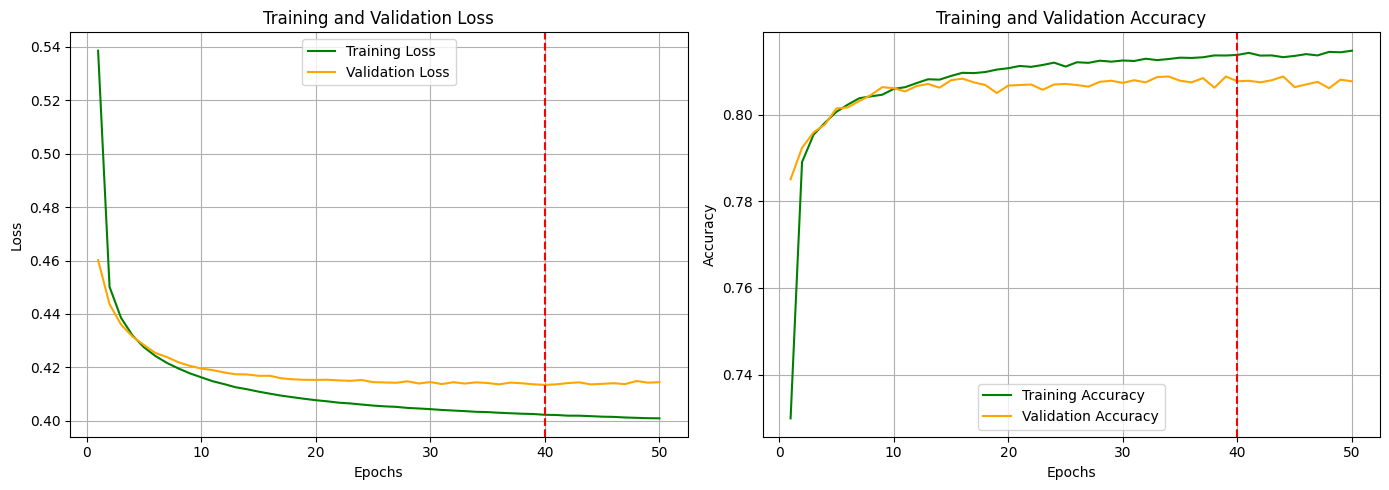

In [21]:
plot_curves(history_2,"model_2")

We see it converging and overfitting a litle bit. Lets try to make more layers in order to generalise. It reaches a better loss though.

## Model 3

In [22]:
model_3 = Sequential([
    Dense(8, activation='relu', input_shape=(X_train_PCA.shape[1],)),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_3.compile(optimizer =Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(X_train_PCA, y_train, epochs=num_epochs, batch_size=batch_size, validation_data= (X_val_PCA,y_val), callbacks=[early_stopping])

Validation loss: 0.41210779547691345, Validation accuracy:0.8108008503913879 


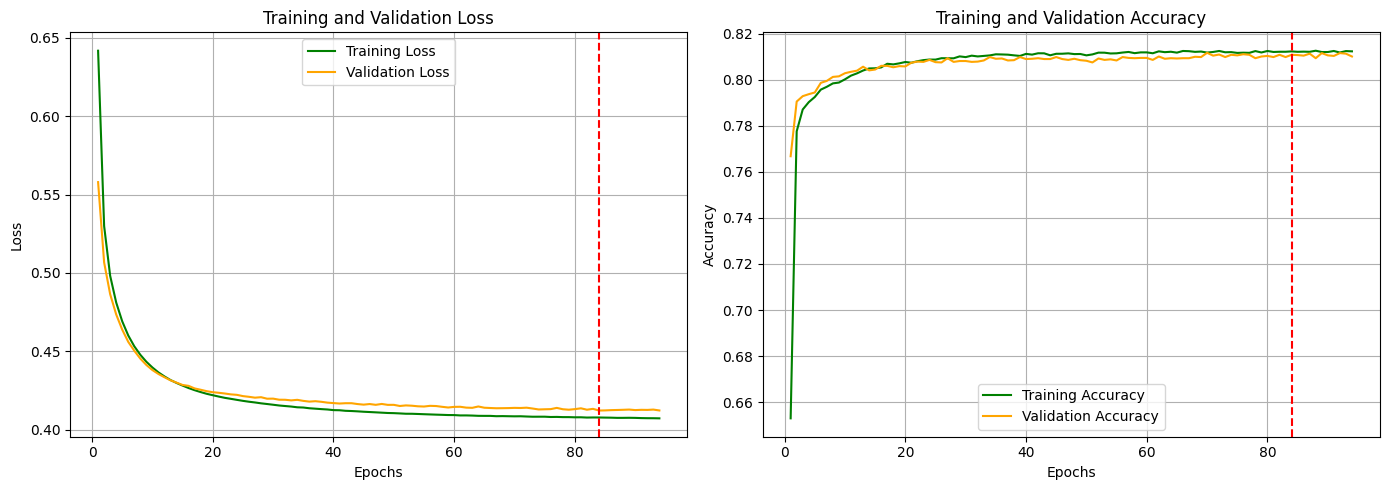

In [24]:
plot_curves(history_3,"model_3")

Pretty good fit, we can try to increase capacity though.

### Model 4

Let's try to make a model that can choose either to not touch the inputs, or to pass them trough the layers. Hopefully it can be useful to regularise

In [61]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(90, activation='relu', input_shape=(X_train_PCA.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
model_4.compile(optimizer = Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
history_4 = model_4.fit(X_train_PCA, y_train, epochs=num_epochs, batch_size=batch_size, validation_data= (X_val_PCA,y_val), callbacks=[early_stopping])

Validation loss: 0.40261101722717285, Validation accuracy:0.8114159107208252 


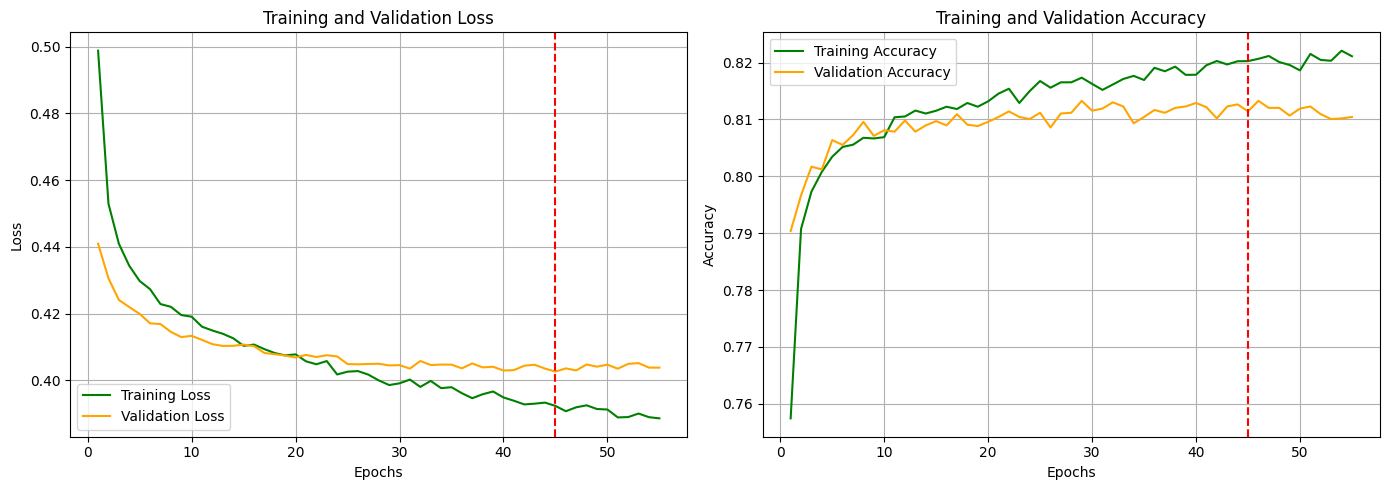

In [64]:
plot_curves(history_4)

Not to good fit, but better loss

## Results

In [ ]:
results = pd.DataFrame(index=['model1', 'model2', 'model3', 'model4'], columns=['Loss', 'Accuracy', 'F1', 'AUC', 'Precision', 'Recall'])

results = cross_validate(model_1,"model1",results)
results = cross_validate(model_2,"model2",results)
results = cross_validate(model_3,"model3",results)
results = cross_validate(model_4,"model4",results)

In [125]:
results.style.background_gradient(cmap='summer_r')

,Loss,Accuracy,F1,AUC,Precision,Recall
model1,0.404403,0.811345,0.810014,0.895810,0.812902,0.807203
model2,0.402449,0.813138,0.811949,0.897896,0.814234,0.809736
model3,0.405436,0.812432,0.811757,0.895503,0.811848,0.811755
model4,0.375933,0.825139,0.821868,0.911732,0.834519,0.809639


Model 4 seems better that 1,2 and 3.

### Results and graphics on test set

In [126]:
y_pred = model_4.predict(X_test_PCA)
y_pred_class = (y_pred >= 0.5).astype(int)

299/299 [==============================] - 1s 2ms/step


In [127]:
    loss,accuracy = model_4.evaluate(X_test_PCA,y_test)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    f1 = f1_score(y_test,y_pred_class)
    auc = roc_auc_score(y_test, y_pred)

299/299 [==============================] - 1s 3ms/step - loss: 0.4109 - accuracy: 0.8069


In [128]:
metrics_dict = {
    'Loss': [loss],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1],
    'AUC': [auc]
}

metrics_df = pd.DataFrame(metrics_dict,index = None)

metrics_df

,Loss,Accuracy,Precision,Recall,F1,AUC
0,0.410937,0.80688,0.813904,0.795692,0.804695,0.893203


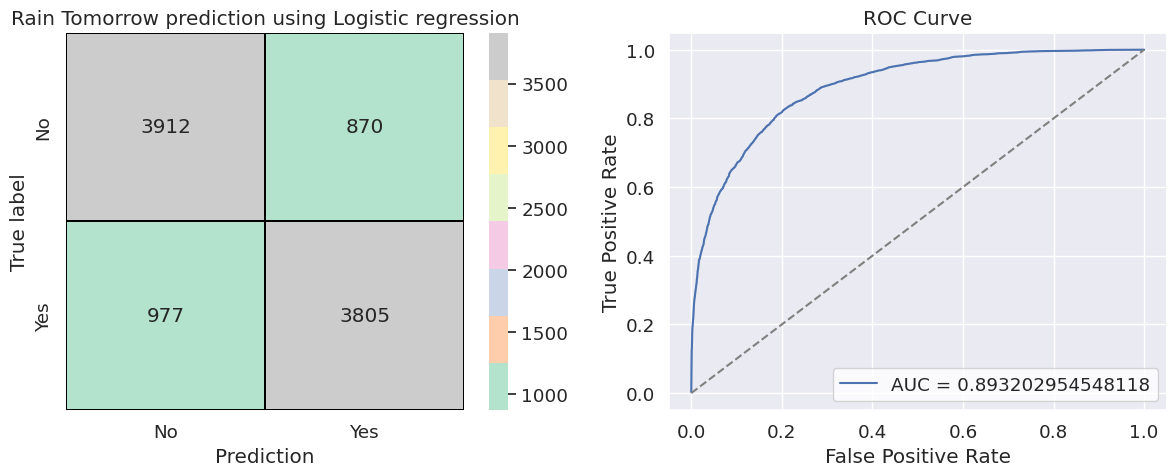

In [129]:
mapping = {'Yes':1,'No':0}
y_test_map = y_test.copy()
y_test_map["RainTomorrow"] = y_test_map["RainTomorrow"].map(mapping)


# Plot confusion matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
conf_matrix = confusion_matrix(y_test, y_pred_class)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Pastel2',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'],
            linecolor='black',linewidths=1.3)
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('Rain Tomorrow prediction using Logistic regression')

# Plot ROC curve
plt.subplot(1, 2, 2)

auc_score = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)

sns.set_style('whitegrid')
sns.lineplot(x=fpr, y=tpr, label=f'AUC = {auc_score}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Predicts better when it will not rain. AUC is quite good.